# 从零开始实现softmax回归分类

## 首先下载 Fashion-MNIST数据集

In [1]:
import mxnet as mx
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from mxnet.gluon import data as gdata
from mxnet.gluon.data.vision import transforms
from mxnet import nd

C:\Users\lenovo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 从gluon模块导入数据集

In [2]:
GPU = mx.gpu()
with mx.Context(GPU):
    trainData = gdata.vision.FashionMNIST(root='./FashionMNIST',train=True,transform=lambda img,labels:(img.astype(np.float32)/255,labels))
    testData =gdata.vision.FashionMNIST(root='./FashionMNIST',train=False,transform=lambda img,labels:(img.astype(np.float32)/255,labels))

In [3]:
trainData[0]

(
 [[[0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]]
 
  [[0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]]
 
  [[0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]


## Fashion-MNIST 中⼀共包括了 10 个类别，分别为： t-shirt（T 恤）、 trouser（裤⼦）、 pullover（套衫）、 dress（连⾐裙）、 coat（外套）、 sandal（凉鞋）、 shirt（衬衫）、 sneaker（运动鞋）、 bag（包）和 ankle boot（短靴）。以下函数可以将数值标签转成相应的文本标签。

In [4]:
def get_fashion_mnist_lables(labels):
    test_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [test_labels[int(i)] for i in labels]
    

In [5]:
def  show_fashion_mnist(images,labels):
    _,figs = plt.subplots(1,len(images),figsize=(12,12))
    for f,img,lbl in zip(figs,images,labels):
        f.imshow(img.reshape(28,28).asnumpy())  #
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)

##  <font color=red>显示图像</font>

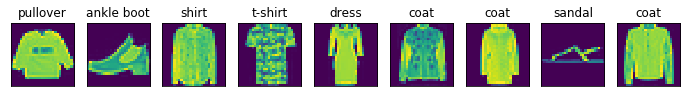

In [6]:
X,y = trainData[0:9]
show_fashion_mnist(X,get_fashion_mnist_lables(y))

## 首先读取小批量数据

`ToTensor()`可以将图像数据从uint8格式编程32位浮点数格式，并且除以255来使所有的像素数值平均在0-1之间。并且`ToTensor()`还将最后一维移到最前一维来方便之后的卷积神经网络计算

In [7]:
# transform = transforms.ToTensor()   #定义一个预处理器
batch_size = 256
#预处理
# trainData=trainData.transform_first(transform,lazy=False)
# testData=testData.transform_first(transform,lazy=False)
#使用Dataloader获取数据

train_iter = gdata.DataLoader(trainData,batch_size,shuffle=True)
test_iter  = gdata.DataLoader(testData,batch_size,shuffle=False)

## 开始实现$softmax$

In [8]:
from mxnet import autograd,nd

## 实现一个一层的神经网络其中输入为 784维，输出层为10维，分别为每个类别概率

In [9]:
num_inputs = 784
num_outputs = 10
with mx.Context(GPU):
    W = nd.random.normal(scale=0.01,shape=(num_inputs,num_outputs))
    b = nd.zeros(shape=num_outputs)

In [10]:
W.attach_grad()
b.attach_grad()

## 下面实现softmax运算符

In [11]:
def softmax(X):
    X_exp = X.exp()   #首先进行指数运算
    partition = X_exp.sum(axis = 1,keepdims = True)  #对每一行进行求和
    return X_exp/partition

## 定义单层的神经网络模型

In [12]:
def net(X):
    return softmax(nd.dot(X.reshape(-1,num_inputs),W)+b)

## 定义损失函数

In [13]:
def cross_entropy(y_hat,y):
    return  -nd.pick(y_hat,y).log()

## 定义优化模型

In [14]:
#随机梯度下降
def sgd(params,lr,batchsize):
    for param in params:
        param[:] = param[:] - lr*param.grad/batchsize    

## 计算分类的准确率

In [15]:
def accuracy(y_hat,y):
     return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()

## 评价模型的准确率

In [16]:
def evaluate_accuracy(data_iter,net):
    acc = 0
    for X,y in data_iter:
        acc += accuracy(net(X),y)
    return acc / len(data_iter)

In [20]:
with mx.Context(GPU):
    print(evaluate_accuracy(test_iter,net))

0.14306640625


## 训练模型

In [28]:
num_epochs,lr = 5,0.1

def train_softmax(net,train_iter,test_iter,loss,num_epochs,batch_size,
                 params=None ,lr=None,trainer=None):
    for epoch in range(num_epochs):
        train_l_sum=0
        train_acc_sum=0
        
        for X,y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat,y)
            l.backward()
            if trainer is None:
                sgd(params,lr,batch_size)
            else:
                trainer.step(batch_size)
            train_l_sum += l.mean().asscalar()
            train_acc_sum += accuracy(y_hat,y)
        test_acc = evaluate_accuracy(test_iter,net)
        print('epoch %d,loss %.4f,train acc %.3f,test acc %.3f'
              %(epoch+1,train_l_sum/len(train_iter),train_acc_sum/len(train_iter),test_acc))

In [29]:
with mx.Context(GPU):
    train_softmax(net,train_iter,test_iter,cross_entropy,num_epochs,batch_size,[W,b],lr)

epoch 1,loss 0.4779,train acc 0.838,test acc 0.845
epoch 2,loss 0.4698,train acc 0.840,test acc 0.839
epoch 3,loss 0.4623,train acc 0.842,test acc 0.848
epoch 4,loss 0.4565,train acc 0.844,test acc 0.847
epoch 5,loss 0.4519,train acc 0.846,test acc 0.850


## 查看预测结果

In [24]:
for X,y in test_iter:
    break


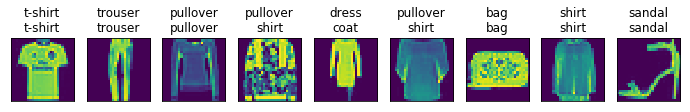

In [30]:
true_labels = get_fashion_mnist_lables(y.asnumpy())
pred_labels = get_fashion_mnist_lables(net(X).argmax(axis=1).asnumpy())
title = [true + '\n' + pred for true,pred in zip(true_labels,pred_labels)]
show_fashion_mnist(X[0:9],title[0:9])

In [31]:
W


[[-0.01328594  0.00681502 -0.0099612  ...  0.00984305  0.00234396
   0.00567305]
 [ 0.00432658  0.01270916  0.00888368 ... -0.00595495 -0.00734482
  -0.00292461]
 [ 0.00529506 -0.00740028  0.01790443 ... -0.0167184  -0.00534421
  -0.00852538]
 ...
 [-0.0075715  -0.00581555  0.04920787 ... -0.02183393 -0.03283391
  -0.01413574]
 [-0.01442397  0.00455233  0.00716288 ... -0.0053139  -0.00168007
   0.0041834 ]
 [ 0.00923141 -0.00654171 -0.00443398 ...  0.00410261 -0.02927653
  -0.01119733]]
<NDArray 784x10 @gpu(0)>